In [1]:
from omegaconf import OmegaConf as om
from mosaicfm.model import ComposerSCGPTModel
from mosaicfm.tasks import get_batch_embeddings
from mosaicfm.tokenizer import GeneVocab
import torch
import scanpy as sc
import numpy as np
import json
import os

from typing import Optional
import gc

import pandas as pd
import anndata
from sklearn.neighbors import kneighbors_graph


from mosaicfm.model import SCGPTModel
from omegaconf import DictConfig
from tqdm.auto import tqdm
from scgpt.data import DataCollator, CountDataset

import matplotlib.pyplot as plt
%matplotlib inline

/home/shreshth/miniforge3/envs/mosaicfm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_lisi_scores(emb, labels, k):
    nng = kneighbors_graph(emb, n_neighbors=k).tocoo()
    labels = pd.Categorical(labels).codes
    self_id = labels[nng.row]
    ne_id = labels[nng.col]

    _, c = np.unique(labels, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [3]:
model_paths= {
"scgpt-70m-2048": "/vevo/scgpt/checkpoints/release/scgpt-70m-2048/",
"scgpt-70m-1024": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024/",
"scgpt-70m-1024-cell-cond": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-cell-cond/",
"scgpt-70m-1024-right-bin": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-right-bin",
"scgpt-70m-1024-fix-norm":"/vevo/scgpt/checkpoints/release/scgpt-70m-1024-fix-norm",
"scgpt-70m-1024-swiglu-mvc-scaled":"/vevo/scgpt/checkpoints/release/scgpt-70m-1024-swiglu-mvc-scaled",
"scgpt-70m-2048-fix-norm":"/vevo/scgpt/checkpoints/release/scgpt-70m-2048-fix-norm",
"scgpt-70m-1024-fix-norm-legacy-data": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-fix-norm-legacy-data",
"scgpt-70m-1024-fix-norm-right-bin": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-fix-norm-right-bin",
"scgpt-70m-1024-fix-norm-apr24-data":"/vevo/scgpt/checkpoints/release/scgpt-70m-1024-fix-norm-apr24-data",
"scgpt-70m-1024-log1p-no-attn-mask":"/vevo/scgpt/checkpoints/release/scgpt-70m-1024-log1p-no-attn-mask",
"scgpt-70m-no-attn-mask": "/vevo/scgpt/checkpoints/release/scgpt-70m-no-attn-mask"
} 
# Sync s3://vevo-ml-datasets/vevo-scgpt/models/release/ to /vevo/scgpt/checkpoints/release/
# If you used an s3 mount when creating your RunAI job then use that path instead
model_name = "scgpt-70m-1024-log1p-no-attn-mask"

In [4]:
sample_data_path = "/home/shreshth/data/Kim2020_Lung.h5ad"
# Download from https://drive.usercontent.google.com/download?id=1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL&authuser=0
vocab_path = os.path.join(model_paths[model_name], "vocab.json")
vocab = GeneVocab.from_file(vocab_path)
adata = sc.read_h5ad(sample_data_path)

# gene_col = "feature_name"
gene_col = "gene_name"
# cell_type_key = "cell_line_orig"
cell_type_key = "cell_type"
# batch_key = "dataset_id"
batch_key = "sample"

adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
print(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
adata = adata[:, adata.var["id_in_vocab"] >= 0]

vocab.set_default_index(vocab["<pad>"])
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

match 20563/20793 genes in vocabulary of size 60736.


Embedding cells:   0%|          | 0/32493 [00:00<?, ?it/s]'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
Embedding cells:  32%|███▏      | 10560/32493 [01:30<03:04, 119.06it/s]'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this target (ignoring processor)
'sm_90' is not a recognized processor for this

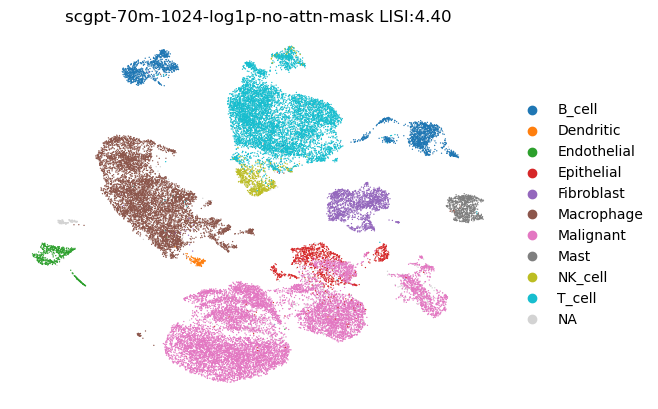

In [7]:
model_config_path = os.path.join(model_paths[model_name], "model_config.yml")
collator_config_path = os.path.join(model_paths[model_name], "collator_config.yml")
model_file =  os.path.join(model_paths[model_name], "best-model.pt")
# model_file = "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-fix-norm-apr24-data/ep2-ba20000-rank0.pt"
model_config = om.load(model_config_path)
collator_config = om.load(collator_config_path)


model = ComposerSCGPTModel(model_config = model_config,
                          collator_config = collator_config)

model.load_state_dict(torch.load(model_file)["state"]["model"],
                     strict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# get cell embeddings
cell_embeddings = get_batch_embeddings(
    adata=adata,
    model=model.model,
    vocab=vocab,
    gene_ids=gene_ids,
    model_cfg=model_config,
    collator_cfg=collator_config,
    batch_size=64,
    max_length=4096,
    return_gene_embeddings=False
)
lisi_score = compute_lisi_scores(cell_embeddings, 
                                adata.obs[cell_type_key].values, 
                                20) 
adata.obsm[model_name] = cell_embeddings
sc.pp.neighbors(adata, use_rep=model_name)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} LISI:{lisi_score:.2f}"],
            return_fig=True)
fig.savefig(f"plots/{model_name}_mosaic.png", dpi=300, bbox_inches="tight")